In [1]:
# usual suspects
import pandas as pd
import numpy as np
from collections import Counter
import math
from tqdm import tqdm

# NLP stuff:
import spacy
from exploration import *
import textacy
import textacy.preprocessing as tprep
import en_core_web_sm
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex

# SILENCE!
import warnings
warnings.filterwarnings("ignore")

---
<div class="alert alert-block alert-info">
    
### About this notebook:
Here we are doing a quick POC using SpaCy to extract the most common "noun phrases" found in movie descriptions.

See page 116 of "Blueprints for Text Analytics Using Python".
    
</div>

---
### Import Data:

In [2]:
df = pd.read_csv('data/movie_descriptions.csv')
df.head()

,id,movie_id,imdb_id,title,description,genres
0,1,675353,12412888.0,Sonic the Hedgehog 2,"After settling in Green Hills, Sonic is eager ...","[28, 878, 35, 10751, 12]"
1,2,453395,9419884.0,Doctor Strange in the Multiverse of Madness,"Doctor Strange, with the help of mystical alli...","[14, 28, 12]"
2,3,629542,8115900.0,The Bad Guys,When the infamous Bad Guys are finally caught ...,"[16, 35, 28, 10751, 80]"
3,4,414906,1877830.0,The Batman,"In his second year of fighting crime, Batman u...","[80, 9648, 53]"
4,5,335787,1464335.0,Uncharted,"A young street-smart, Nathan Drake and his wis...","[28, 12]"


In [3]:
# fill in missing values:
df['description'] = df['description'].fillna('Missing')

In [4]:
# load spacy model and set custome tokenizer:
nlp = spacy.load('en_core_web_sm', disable=[])
nlp.tokenizer = custom_tokenizer(nlp)
nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())

# create new columns in original df to store output from SpaCy:
for col in nlp_columns:
    df[col] = None

# set batch size for cospus processing:s
batch_size = 50
batches = math.ceil(len(df) / batch_size)

# process documents:
for i in tqdm(range(0, len(df), batch_size), total=batches):
    docs = nlp.pipe(df['description'][i:i+batch_size])
    # append to df:
    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df[col].iloc[i+j] = values

100%|█████████████████████████████████████████| 200/200 [01:09<00:00,  2.86it/s]


---
### Count the most commong noun phrases:

progress-bar: 100%|███████████████████| 10000/10000 [00:00<00:00, 317882.75it/s]


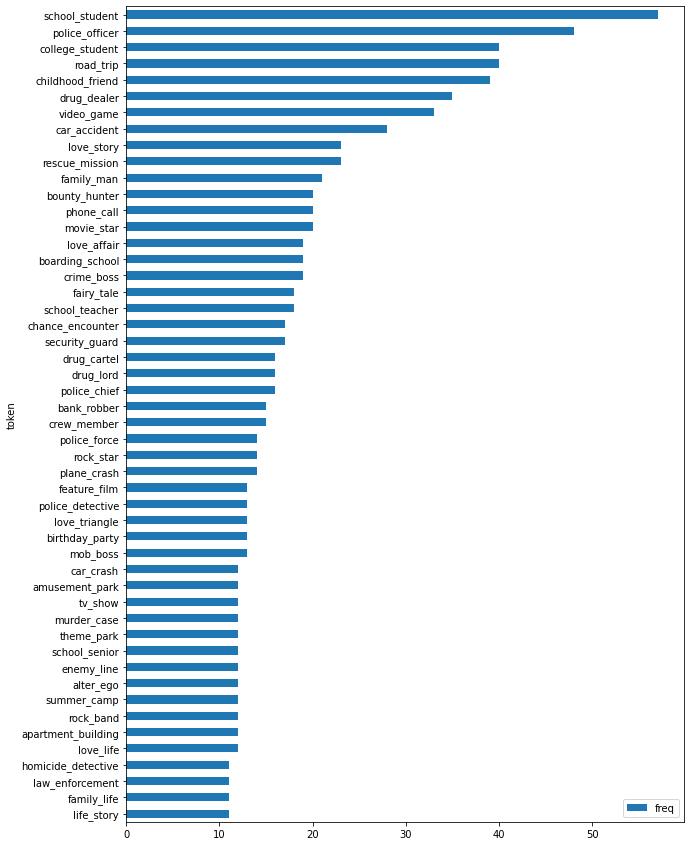

In [5]:
count_words(df, column='noun_phrases', preprocess=None, min_freq=2).head(50).plot(kind='barh', figsize=(10,15)).invert_yaxis()

In [6]:
df.head()

,id,movie_id,imdb_id,title,description,genres,lemmas,adjs_verbs,nouns,noun_phrases,adj_noun_phrases,entities
0,1,675353,12412888.0,Sonic the Hedgehog 2,"After settling in Green Hills, Sonic is eager ...","[28, 878, 35, 10751, 12]","[after, settle, in, Green, Hills, Sonic, be, e...","[settle, eager, prove, take, true, come, retur...","[Green, Hills, Sonic, hero, test, Dr., Robotni...",[],"[true_hero, new_partner, sonic_team, own_sidek...","[Green_Hills/GPE, Sonic/ORG, Robotnik/PERSON, ..."
1,2,453395,9419884.0,Doctor Strange in the Multiverse of Madness,"Doctor Strange, with the help of mystical alli...","[14, 28, 12]","[Doctor, Strange, with, help, of, mystical, al...","[mystical, old, new, traverse, mind-bending, d...","[Doctor, Strange, help, ally, reality, Multive...",[],"[mystical_ally, alternate_reality, new_adversary]",[Multiverse/ORG]
2,3,629542,8115900.0,The Bad Guys,When the infamous Bad Guys are finally caught ...,"[16, 35, 28, 10751, 80]","[when, infamous, bad, guy, be, finally, catch,...","[infamous, bad, catch, countless, most-wanted,...","[guy, year, heist, world, villain, Mr., Wolf, ...",[],"[bad_guy, countless_heist, most-wanted_villain]","[bad_guy/PERSON, Wolf/PERSON]"
3,4,414906,1877830.0,The Batman,"In his second year of fighting crime, Batman u...","[80, 9648, 53]","[in, second, year, of, fight, crime, Batman, u...","[second, fight, connect, face, serial, know]","[year, crime, Batman, uncover, corruption, Got...",[uncover_corruption],"[second_year, own_family, serial_killer]","[Batman/ORG, Gotham_City/GPE]"
4,5,335787,1464335.0,Uncharted,"A young street-smart, Nathan Drake and his wis...","[28, 12]","[young, street-smart, Nathan, Drake, and, wise...","[young, wisecrack, dangerous, great, find, tra...","[street-smart, Nathan, Drake, partner, Victor,...",[],"[young_street-smart, dangerous_pursuit, great_...","[Nathan_Drake/PERSON, Victor_""/PERSON, Sulliva..."
